<a href="https://colab.research.google.com/github/Noam-Coh3n/MLLM_practical/blob/main/Practical_Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Notebook 1: Assessing Language Model Performance

## Please download to be able to save your answers in this notebook!

The practical is based around the paper [Marks and Tegmark (2023) The Geometry of Truth](https://arxiv.org/abs/2310.06824). In this paper, the authors examine the internal activations of large language models and find that true and false statements are linearly separable within the model.

In this first notebook, you will:

1. (0.5 pt) Assess the performance of a small model on one of Marks and Tegmark's datasets,
2. (1 pt) Examine how phrasing the prompt can make a difference to the performance of the model,
3. (2 pt) Evaluate the model on another dataset, and
4. (1.5 pt) Assess the performance of the model on this second dataset in comparison to a majority class baseline.

**Note**

In this notebook, we use the Llama-3.2 1B model. Before starting the tutorial, please go to the model's [huggingface page](https://huggingface.co/meta-llama/Llama-3.2-1B) and request permission to use the model.

## 0. Setup

In the practical, we will be using the package nnsight. In this notebook, we could technically get away without using it, but let's install and use it anyway, for practice.

In [ ]:
# This simply clears the outputs of a cell after running,
# so we don't see all the installation messages.
from IPython.display import clear_output
aaaaaa

# Here we install the package nnsight
!pip install nnsight>0.5.0

clear_output()

When you signed up for model access, you probably obtained a [huggingface access token](https://huggingface.co/docs/hub/en/security-tokens). Here, you can use it to log in to this notebook.

In [ ]:
# Here, we log in to the huggingface hub with our access token
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# We import some packages we will need, and set our random seeds (or try to!)
import random
import torch

random.seed(12)
torch.manual_seed(12)
torch.cuda.manual_seed(12)

## 1. Evaluating the model

LMs seem to be able to classify true and false statements in-context. Here, we will test how well that happens in a small model: Llama-3.2-1B.

We will be using [nnsight](https://nnsight.net/). nnsight allows us to run a model whilst keeping track of its internal states easily.

To run a model, we need to set up the model as an nnsight LanguageModel. The class LanguageModel acts as a wrapper for any model from the transformers library.

In [ ]:
# Here, we import the nnsight package, as well as a helper function clear_output
import nnsight

# We set up our chosen model as an nnsight LanguageModel. To change model, simply
# change the string "meta-llama/Llama-3.2-1B" to another huggingface model.
model = nnsight.LanguageModel("meta-llama/Llama-3.2-1B", device_map="auto")

clear_output()

# We can print out the structure of the model.
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (ro

When we print out the model, we should get the following output.

This tells us that we have a LlamaModel with an Embedding layer going from a vocabulary of 128256 tokens to embeddings of dimension 2048.

We then have 16 LlamaDecoderLayers - aka Transformer blocks. Each of these consists of a self attention layer, an MLP, and two normalization components.

We then have another normalization component and the positional embeddings.

Finally, the component lm_head is a linear layer (aka a matrix) that goes from the 2048 dimensional embeddings to the 128256 dimensional vocabulary.

``` py
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (lm_head): Linear(in_features=2048, out_features=128256, bias=False)
  (generator): Generator(
    (streamer): Streamer()
  )
)
```

### Setting the Prompt Template.
A prompt is a sequence of words you give the language model for it to respond to. We are going to assess this language model on one of the datasets from Marks and Tegmark. In order to do so, we set up a prompt template.

In [ ]:
# We set up a prompt to see if models can correctly classify true and false statements.
CITIES_PROMPT_TEMPLATE = """The city of Tokyo is in Japan. This statement is: TRUE
The city of Hanoi is in Poland. This statement is: FALSE
{statement} This statement is:"""

source_statement = "The city of Toronto is in Canada." # true
source_prompt = CITIES_PROMPT_TEMPLATE.format(statement=source_statement)
base_statement = "The city of Chicago is in Canada." # false
base_prompt = CITIES_PROMPT_TEMPLATE.format(statement=base_statement)

# This should output FALSE if we give it to the model.
print(base_prompt)

The city of Tokyo is in Japan. This statement is: TRUE
The city of Hanoi is in Poland. This statement is: FALSE
The city of Chicago is in Canada. This statement is:


### Downloading the dataset
We will now download the cities dataset from the paper, split it into train and test, and assess the model performance on the training set.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/saprmarks/geometry-of-truth/refs/heads/main/datasets/cities.csv')
print(f'This dataset has {len(df)} items')

# We can use train_test_split on a dataframe exactly as we are used to.
Xtrain, Xtest, ytrain, ytest = train_test_split(df.statement, df.label, test_size=0.2, random_state=12)
Xtrain.head()

This dataset has 1496 items


,statement
320,The city of Kakamega is in Kenya.
1122,The city of Jiaozuo is in China.
932,The city of Sofia is in Bulgaria.
511,The city of Kaifeng is in Mexico.
700,The city of Comilla is in Bangladesh.


### Assessing the model on the dataset
In the code below, we will evaluate the model on this dataset. Notice a few things. We use the context `with torch.no_grad():`. Since we are only evaluating the model, we do not need to save all the data from the forward pass that is needed for the backwards pass. We therefore tell the model not to save information needed for the gradients, i.e. `torch.no_grad()`.

We also use a context `with model.trace(base_prompt) as trace:` from nnsight that is not strictly necessary. When we run a model ith a trace, it means that we are able to access all the information occurring inside the model. This will be necessary in the next notebook, but we just introduce it here for practice.

We save the logits from the model output. Recall that the logits are the log of the probabilities of each token in the vocabulary (128256 tokens). We therefore want to take the highest value of the logits and return the index corresponding to this. We then decode this index into a text token.

In [ ]:
from tqdm import trange
import torch

predictions = []

with torch.no_grad():
  # We run the model over the dataset
  for i in trange(len(Xtrain)):
    statement = Xtrain.iloc[i]
    prompt = CITIES_PROMPT_TEMPLATE.format(statement=statement)
    with model.trace(prompt) as trace:
      # Recall that the logits are the log of the probabilities
      logits = model.output.logits.save()

    # Take the index of the highest logit and decode to a text token
    predictions.append(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))



  0%|          | 0/1196 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

100%|██████████| 1196/1196 [02:09<00:00,  9.25it/s]


Let's look at the predictions: are they well formatted?


In [ ]:
print(set(predictions))

('The city of Kakamega is in Kenya.', ' TRUE') ('The city of Jiaozuo is in China.', ' TRUE') ('The city of Sofia is in Bulgaria.', ' TRUE') ('The city of Kaifeng is in Mexico.', ' TRUE') ('The city of Comilla is in Bangladesh.', ' TRUE') ('The city of Wuzhou is in Syria.', ' TRUE') ('The city of Cixi is in Indonesia.', ' TRUE') ('The city of Fuxin is in China.', ' TRUE') ('The city of Shangyu is in China.', ' TRUE') ('The city of Arequipa is in Peru.', ' TRUE') ('The city of Dombivli is in Mali.', ' FALSE') ('The city of Mukalla is in Yemen.', ' TRUE') ('The city of Reynosa is in Mexico.', ' TRUE') ('The city of Zhenjiang is in China.', ' TRUE') ('The city of Bien Hoa is in South Korea.', ' TRUE') ('The city of Ziyang is in China.', ' TRUE') ('The city of Konya is in Turkey.', ' TRUE') ('The city of Foshan is in China.', ' TRUE') ('The city of Wanxian is in Algeria.', ' TRUE') ('The city of Tegucigalpa is in China.', ' TRUE') ('The city of Quzhou is in Vietnam.', ' TRUE') ('The city of

In [ ]:
numeric_predictions = [1 if p == ' TRUE' else 0 for p in predictions]
from sklearn.metrics import accuracy_score
acc = accuracy_score(ytrain, numeric_predictions)
print(f"The accuracy is: {acc}")

The accuracy is: 0.9055183946488294


(0.5 pt) The accuracy is pretty low. Why is that? (Check the predictions)

The model seems to be heavily biased towards predicting ``TRUE``, it picked this value in over $97\%$ of cases (see code below).

In [ ]:
true_preds = predictions.count(" TRUE")
false_preds = predictions.count(" FALSE")

print(f'The model predicted "TRUE" {true_preds} times ({true_preds/(true_preds+false_preds):.1%} of cases), while predicting "FALSE" only {false_preds} times.')

The model predicted "TRUE" 1166 times (97.5% of cases), while predicting "FALSE" only 30 times.


## 2. Phrasing the Prompt Differently
 Language models can be very sensitive to the way that they are prompted. Below, we will change the order of the true and false statements in the prompt template, and rerun.

In [ ]:
# Change the order of the true and false statements in the prompt template
CITIES_PROMPT_TEMPLATE = """The city of Hanoi is in Poland. This statement is: FALSE
The city of Tokyo is in Japan. This statement is: TRUE
{statement} This statement is:"""

(1 pt) Now,

a. Rerun the model on the dataset using this new prompt format and save the predictions (0.5 pt).

b. calculate the accuracy (0.5 pt).

In [ ]:
# Part 2a. (0.5 pt) Run the model over the new prompt format and save the predictions
predictions = []

with torch.no_grad():
  # We run the model over the dataset
  for i in trange(len(Xtrain)):
    statement = Xtrain.iloc[i]
    prompt = CITIES_PROMPT_TEMPLATE.format(statement=statement)
    with model.trace(prompt) as trace:
      # Recall that the logits are the log of the probabilities
      logits = model.output.logits.save()

    # Take the index of the highest logit and decode to a text token
    predictions.append(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

100%|██████████| 1196/1196 [01:15<00:00, 15.91it/s]


In [ ]:
# Check whether the predictions are well formatted - not too chatty
print(set(predictions))

{' TRUE', ' FALSE'}


In [ ]:
# Part 2b. (0.5 pt) Assess the accuracy of the predictions
numeric_predictions = [1 if p == ' TRUE' else 0 for p in predictions]
acc = accuracy_score(ytrain, numeric_predictions)
print(f"The accuracy is: {acc}")

The accuracy is: 0.9055183946488294


## 3. Assessing the model on another dataset.
We have seen that with the right prompt, this model can tell the difference between true and false statements about cities. We will now look at another dataset from the paper.

The dataset `sp_en_trans.csv` is a dataset of correct and incorrect Spanish to English translations.

You will

a. (0.5 pt) Download the dataset `sp_en_trans.csv` from Marks and Tegmark and split into train and test.

b. (0.5 pt) Develop a new prompt template.

c. (0.5 pt) Assess the model on the train dataset, and

d. (0.5 pt) Calculate the accuracy of the model on the dataset.

**Note**: performance on this dataset is very dependent on the items that are in the prompt template. Do not worry about getting very good performance - this model does not do so well on this dataset. In particular, don't spend lots of time 'engineering' the prompt for better performance. You could try one or two different options, but that is not compulsory.

Once you have the output, you will check in part 4 whether the model is significantly better than a majority class baseline.

In [ ]:
# Part 3a.
# Download the dataset from github
df = pd.read_csv('https://raw.githubusercontent.com/saprmarks/geometry-of-truth/refs/heads/main/datasets/sp_en_trans.csv')

# Split the dataset into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(df.statement, df.label, test_size=0.2, random_state=12)

In [ ]:
# Part 3b.
# Set up a prompt template for this model. Make sure the correct and incorrect
# examples are not in the dataset itself.
SpEn_PROMPT_TEMPLATE = """The Spanish word 'chico' means 'math'. This statement is: FALSE
The Spanish word 'banca' means 'bench'. This statement is: TRUE
{statement} This statement is:"""

SpEn_PROMPT_TEMPLATE_FLIP = """The Spanish word 'banca' means 'bench'. This statement is: TRUE
The Spanish word 'chico' means 'math'. This statement is: FALSE
{statement} This statement is:"""


In [ ]:
# Part 3c.
# Run the model and save the predictions
predictions = []
predictions_flip = []

with torch.no_grad():
  # We run the model over the dataset
  for i in trange(len(Xtrain)):
    statement = Xtrain.iloc[i]
    prompt = SpEn_PROMPT_TEMPLATE.format(statement=statement)
    prompt_flip = SpEn_PROMPT_TEMPLATE_FLIP.format(statement=statement)
    with model.trace(prompt) as trace:
      # Recall that the logits are the log of the probabilities
      logits = model.output.logits.save()

    # Take the index of the highest logit and decode to a text token
    predictions.append(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

    with model.trace(prompt_flip) as trace:
      # Recall that the logits are the log of the probabilities
      logits = model.output.logits.save()

    # Take the index of the highest logit and decode to a text token
    predictions_flip.append(model.tokenizer.decode(logits.argmax(dim=-1)[0, -1]))

100%|██████████| 283/283 [00:35<00:00,  7.91it/s]


In [ ]:
# Part 3d.
numeric_predictions = [1 if p == ' TRUE' else 0 for p in predictions]
acc = accuracy_score(ytrain, numeric_predictions)
print(f"The accuracy is: {acc}")


numeric_predictions_flip = [1 if p == ' TRUE' else 0 for p in predictions_flip]
acc_flip = accuracy_score(ytrain, numeric_predictions_flip)
print(f"The accuracy with the flipped prompt is: {acc_flip}")

The accuracy is: 0.7526501766784452
The accuracy with the flipped prompt is: 0.49823321554770317


## 4. Testing against a majority baseline

**1.5 pt** Evaluate whether the accuracy of the model on the train set is significantly better than a majority baseline.

In [ ]:
import numpy as np

# (0.5 pt) What is the accuracy of the majority baseline classifier?
freqs = ytrain.value_counts()
maj = freqs.idxmax()
maj_acc = max(freqs) / len(ytrain)

print(f"The majority class is {maj} and the corresponding baseline accuracy is {maj_acc}.")

# (1 pt) Choose a technique that will allow you to evaluate whether the model accuracy
# is significantly higher than the majority baseline, implement it,
# and assess whether the model performance is significantly higher than the baseline.

# We use bootstrapping with 1000 bootstraps to generate a distribution of accuracy values for the model and the baseline.
num_bootstraps = 1000
np.random.seed(12)

model_acc = []
maj_base_acc = []

for _ in range(num_bootstraps):
    # randomly select indices with replacement from the test set.
    idx = np.random.choice(len(ytrain), size=len(ytrain), replace=True)

    # select from the test targets and your predictions
    ytrain_i = np.array(ytrain)[idx]
    model_pred_i = np.array(numeric_predictions)[idx]
    maj_base_pred_i = np.repeat(maj, len(ytrain_i))

    # Calculate accuracy for model and baseline and save to your variable.
    model_acc.append(accuracy_score(ytrain_i, model_pred_i))
    maj_base_acc.append(accuracy_score(ytrain_i, maj_base_pred_i))

The majority class is 0 and the corresponding baseline accuracy is 0.5017667844522968.


NormaltestResult(statistic=np.float64(0.6082853540510066), pvalue=np.float64(0.7377555981667921))

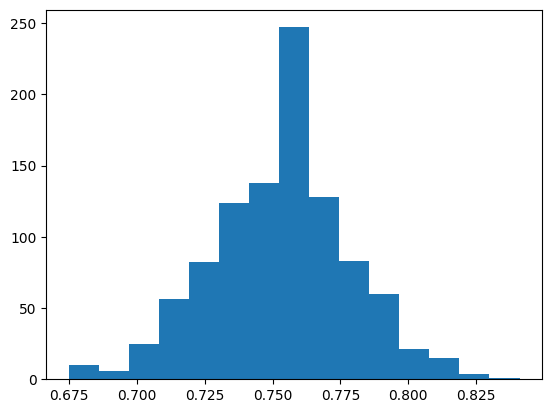

In [ ]:
from scipy.stats import normaltest
import matplotlib.pyplot as plt

plt.hist(model_acc, bins=15)

normaltest(model_acc)

NormaltestResult(statistic=np.float64(1.0123179619584435), pvalue=np.float64(0.6028065291132059))

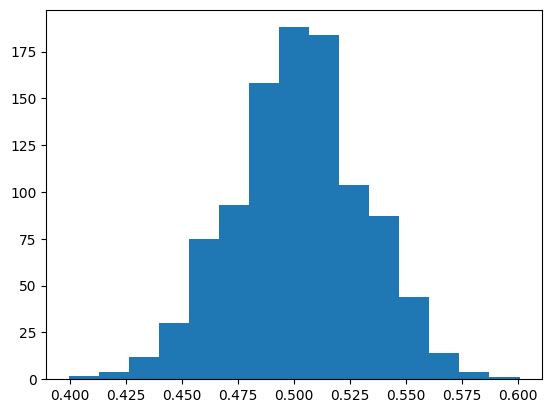

In [ ]:
plt.hist(maj_base_acc, bins=15)

normaltest(maj_base_acc)

As we can see from the histograms and the high $p$-values, the accuracy values seem to be normally distributed. Since the samples were generated by predicting on the same test sets, the values are also paired, so a paired $t$-test is suitable here.

In [ ]:
from scipy.stats import ttest_rel

ttest_rel(model_acc, maj_base_acc, alternative='greater').pvalue

np.float64(0.0)

Since the $p$-value is $0.0$, we can say with (approximately) $100\%$ certainty that the null-hypothesis is false, which strongly supports our alternative hypothesis (that the model yields a higher accuracy than the majority baseline).